# Training the sine wave model

Based on the **hello_world** example from [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview).


In [1]:
# Install TensorFlow if you don't have it yet.
!pip install tensorflow

In [2]:
# Set a "seed" value, so we get the same random numbers each time we run this
# notebook for reproducible results.
import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(1)

In [3]:
import os
from tensorflow import keras
import matplotlib.pyplot as plt
import math

## Dataset

### 1. Generate Data
The code in the following cell will generate a set of random x values, calculate their sine values, and display them on a graph.



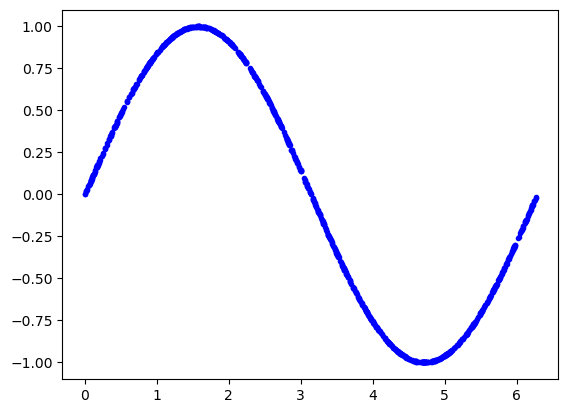

In [4]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

### 2. Add Noise
Since it was generated directly by the sine function, our data fits a nice, smooth curve.

However, machine learning models are good at extracting underlying meaning from messy, real world data. To demonstrate this, we can add some noise to our data to approximate something more life-like.

In the following cell, we'll add some random noise to each value, then draw a new graph:

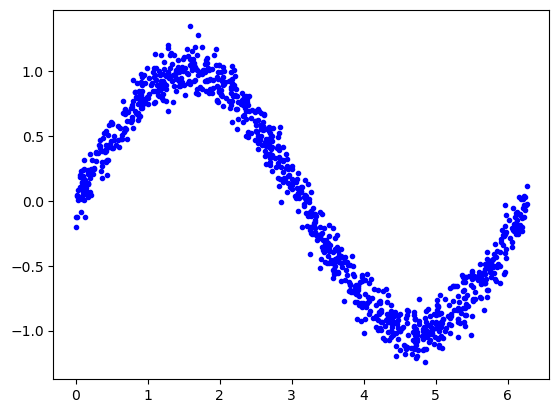

In [5]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

### 3. Split the Data
We now have a noisy dataset that approximates real world data. We'll be using this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing) It's important in both cases that we use fresh data that was not already used to train the model.

The data is split as follows:

Training: 60%

Validation: 20%

Testing: 20%

The following code will split our data and then plots each set as a different color:

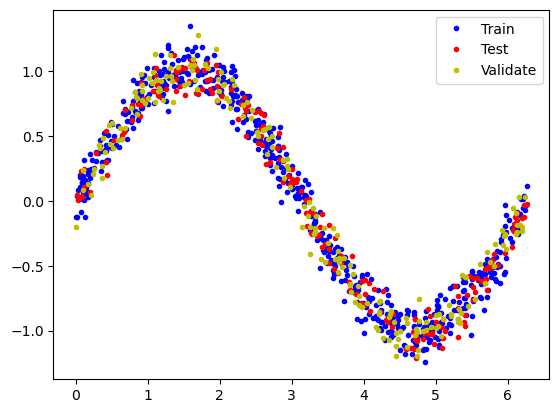

In [6]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


## Training

In [7]:
# If you don't want to train again, load the trained model.
#model = keras.models.load_model("model.h5")

### 1. Design the Model

We're going to build a simple neural network model that will take an input value (in this case, x) and use it to predict a numeric output value (the sine of x). This type of problem is called a regression. It will use layers of neurons to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define two layers. The first layer takes a single input (our x value) and runs it through 8 neurons. Based on this input, each neuron will become activated to a certain degree based on its internal state (its weight and bias values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our y value.

The code in the following cell defines our model using Keras, TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we compile it, specifying parameters that determine how it will be trained:

In [8]:
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second layer may help the network learn more complex representations
model.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/opt/homebrew/Caskroom/miniforge/base/envs/roboenv2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321 (1.25 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

### 2. Train the Model ###

Once we've defined the model, we can use our data to train it. Training involves passing an x value into the neural network, checking how far the network's output deviates from the expected y value, and adjusting the neurons' weights and biases so that the output is more likely to be correct the next time.

Training runs this process on the full dataset multiple times, and each full run-through is known as an epoch. The number of epochs to run during training is a parameter we can set.

During each epoch, data is run through the network in multiple batches. Each batch, several pieces of data are passed into the network, producing output values. These outputs' correctness is measured in aggregate and the network's weights and biases are adjusted accordingly, once per batch. The batch size is also a parameter we can set.

The code in the following cell uses the x and y values from our training data to train the model. It runs for 500 epochs, with 64 pieces of data in each batch. We also pass in some data for validation. As you will see when you run the cell, training can take a while to complete:

In [10]:
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate))

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4756 - mae: 1.0127 - val_loss: 1.3063 - val_mae: 0.9886
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2066 - mae: 0.9360 - val_loss: 1.0936 - val_mae: 0.9226
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0146 - mae: 0.8753 - val_loss: 0.9630 - val_mae: 0.8767
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9027 - mae: 0.8361 - val_loss: 0.8739 - val_mae: 0.8427
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8200 - mae: 0.8032 - val_loss: 0.7938 - val_mae: 0.8069
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7481 - mae: 0.7701 - val_loss: 0.7358 - val_mae: 0.7801
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6940 - mae: 0.7441 - val_loss: 0.6874 - val_mae: 0.7552
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6493 - mae: 0.7206 - val_loss: 0.6457 - val_mae: 0.7318
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.611

### 3. Plot Metrics

Below, we will plot the results of the training by training epoch. 
We will consider the following metrics:
* Mean Squared Error
* Mean Absolute Error

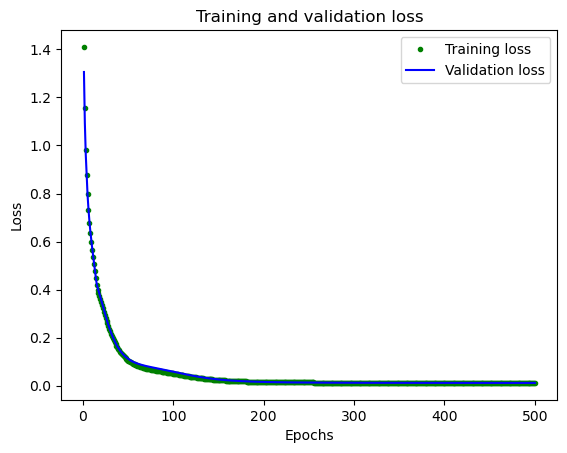

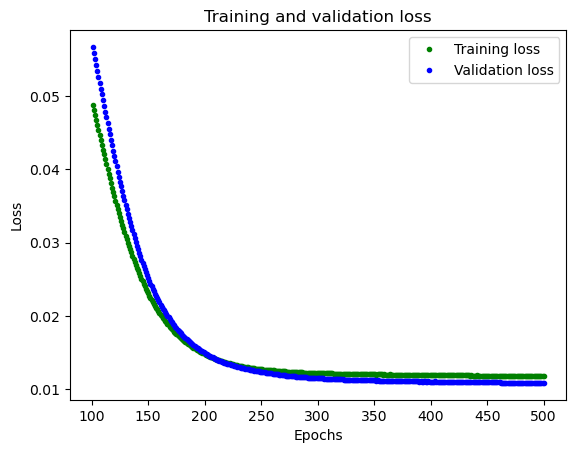

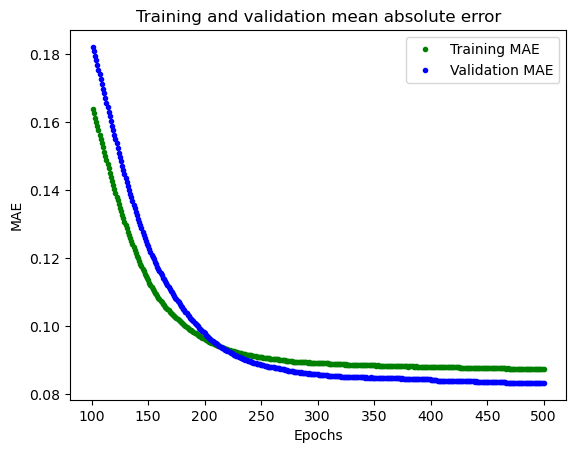

In [11]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.clf()

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

### 4. Check against test set
Here, we use the model to predict the value of the sine wave (y) given the input (x)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.0108 - mae: 0.0829
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


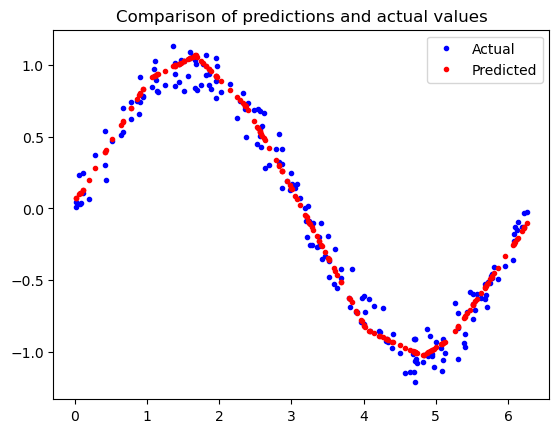

In [12]:
# Calculate and print the loss on our test dataset
loss = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
predictions = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

In [13]:
# Save the trained model just in case we need it again later.
model.save("model.h5")

## NumPy version

Let's see how we can make predictions by hand. It is not practical, but it is a extra step that can help us undestanding what the model does. In fact, if we grab the weights from the layers, we can do the math ourselves, re-implementing the "predict" method of our moldel.

In [14]:
W1, b1 = model.layers[0].get_weights()
W2, b2 = model.layers[1].get_weights()
W3, b3 = model.layers[2].get_weights()

In [15]:
print(W1.shape, b1.shape)
print(W2.shape, b2.shape)
print(W3.shape, b3.shape)

(1, 16) (16,)
(16, 16) (16,)
(16, 1) (1,)


In [16]:
xs = x_test

In [17]:
# This is what the TF model does internally:
ys = []
for x in xs:
    x = np.array([x])       # x should be array
    h1 = x @ W1 + b1        # dense layer
    h1 = np.maximum(0, h1)  # ReLU
    h2 = h1 @ W2 + b2       # dense layer
    h2 = np.maximum(0, h2)  # ReLU
    h3 = h2 @ W3 + b3       # dense layer
    ys.append(h3)

ys = np.stack(ys)

In [18]:
# Are our predictions the same as TF's predictions?
# This should print 0 if the results are close enough.
np.sum(np.abs(ys - predictions) > 1e-6)

0

## Export the weights

Because we don't have an authomatic way to transport our model to cpp that could run on Arduino UNO, we will need to print and export our weights.

In [19]:
# Note that we transpose W2. This makes the inner loop for the
# matrix multiplication a little simpler.

names = ["W1_data", "b1_data", "W2_data", "b2_data", "W3_data", "b3_data"]
arrays = [W1, b1, W2.T, b2, W3, b3]

In [20]:
# Copy this into model_data.cpp:

for name, array in zip(names, arrays):
    print("const float %s[] PROGMEM = {" % name)
    print("   ", ", ".join([str(x) + "f" for x in array.flatten()]))
    print("};\n")

const float W1_data[] PROGMEM = {
    0.27590775f, -0.4722782f, -0.2790939f, 0.40545982f, -0.42545033f, -0.42951077f, 0.5656876f, 0.4903337f, -0.3521313f, 0.11134469f, -0.47502068f, -0.26619047f, -0.07490486f, -0.3656292f, 0.33092827f, -0.28136835f
};

const float b1_data[] PROGMEM = {
    -0.6490899f, 0.0f, 0.0f, 0.8372708f, 0.0f, 0.0f, -0.58637583f, 0.03297836f, 0.0f, -0.31218228f, 0.0f, 0.0f, 0.0f, 0.0f, -0.038793586f, 0.0f
};

const float W2_data[] PROGMEM = {
    0.4014916f, -0.35379446f, 0.1747925f, 0.194606f, -0.23638457f, 0.2763712f, 0.4481723f, 0.566071f, -0.18159312f, -0.29817122f, 0.40641645f, -0.3906979f, 0.34165898f, -0.43086016f, 0.32465166f, 0.018458992f, -0.8520291f, 0.34596726f, -0.07308775f, 0.4523783f, -0.115092814f, 0.046368837f, -0.54667795f, -0.25010404f, 0.25766465f, -0.47116157f, 0.11384633f, -0.2739886f, -0.3175822f, -0.20560862f, 0.16566667f, -0.20682167f, -0.39916912f, 0.009983957f, 0.11779097f, -0.30913812f, 0.33386192f, 0.084747046f, -0.40162754f, -0.283698